In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl 
import random

$$\frac{\partial{\phi}}{\partial{t}}=D\frac{\partial^2{\phi}}{\partial{x^2}}$$

$$\phi(0,t)=\phi_0$$

\begin{equation}
\phi(x)=
    \begin{cases}
        0 & \text{if } x \neq 0\\
        \phi_0 & \text{if } x = 0
    \end{cases}
\end{equation}

In [3]:
tf.keras.backend.set_floatx('float32')

#Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(20, activation='tanh', input_shape=(2,)),
    tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1)
])

In [4]:
def loss(x_pde,x_ini,x_bound,x_bound1):
    
    with tf.GradientTape(persistent=True) as tape:
        
        x,t=tf.unstack(x_pde,axis=1)
        tape.watch(x)
        tape.watch(t)
        
        phi=model(tf.stack((x,t),axis=1))
        dphi_dt=tape.gradient(phi,t)
        dphi_dx=tape.gradient(phi,x)
        d2phi_dx2=tape.gradient(dphi_dx,x)
        
        "Equation loss"
        loss1=tf.reduce_mean(tf.square(dphi_dt-D*d2phi_dx2))
        
        "boundary condition loss"
        xb,tb=tf.unstack(x_bound,axis=1)
        phib=model(tf.stack((xb,tb),axis=1))
        lossb=tf.reduce_mean(tf.square(phib))
        
        "boundary condition loss"
        xb1,tb1=tf.unstack(x_bound1,axis=1)
        phib1=model(tf.stack((xb1,tb1),axis=1))
        lossb1=tf.reduce_mean(tf.square(phib1))
        
        "initial condition loss"
        xi,ti=tf.unstack(x_ini,axis=1)
        phi_i=model(x_ini)
        phi_i_real=4*xi*(1-xi)
        lossi=tf.reduce_mean(tf.square(phi_i-phi_i_real))
    
    return loss1+lossb+lossb1+lossi

In [5]:
#constants
D=1

In [6]:
N=10000
N2=1000

x_l=0
x_r=1
t_s=0
t_e=1.5

#Domain 
x=(x_r-x_l)*np.random.rand(N,1)+x_l
t=(t_e-t_s)*np.random.rand(N,1)+t_s

x=np.reshape(x,-1)
t=np.reshape(t,-1)
xt = np.concatenate([x[:, None], t[:, None]], axis=1)
XT=tf.convert_to_tensor(xt, dtype=tf.float32, dtype_hint=None, name=None)

#phi(0,t): Boundary condition
xb1=x_l*np.ones((N2,1))
tb1=(t_e-t_s)*np.random.rand(N2,1)+t_s
xb1=np.reshape(xb1,-1)
tb1=np.reshape(tb1,-1)
x_bound1 = np.concatenate([xb1[:, None], tb1[:, None]], axis=1)
X_bound1=tf.convert_to_tensor(x_bound1, dtype=tf.float32, dtype_hint=None, name=None)

xb2=x_r*np.ones((N2,1))
tb2=(t_e-t_s)*np.random.rand(N2,1)+t_s
xb2=np.reshape(xb2,-1)
tb2=np.reshape(tb2,-1)
x_bound2 = np.concatenate([xb2[:, None], tb2[:, None]], axis=1)
X_bound2=tf.convert_to_tensor(x_bound2, dtype=tf.float32, dtype_hint=None, name=None)

x_bound=np.concatenate([x_bound1,x_bound2],axis=0)
X_bound=tf.convert_to_tensor(x_bound, dtype=tf.float32, dtype_hint=None, name=None)

#phi(x,0): Initial condition at t=0
xi=(x_r-x_l)*np.random.rand(2*N2,1)+x_l
ti=np.zeros((2*N2,1))
xi=np.reshape(xi,-1)
ti=np.reshape(ti,-1)
x_ini = np.concatenate([xi[:, None], ti[:, None]], axis=1)
X_ini=tf.convert_to_tensor(x_ini, dtype=tf.float32, dtype_hint=None, name=None)

In [7]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam()

# Train the model
for epoch in range(5000):
    with tf.GradientTape() as tape:
        loss_value = loss(XT,X_ini,X_bound1,X_bound2)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss={loss_value:.6f}")

Epoch 0, loss=0.875157
Epoch 100, loss=0.218235
Epoch 200, loss=0.201993
Epoch 300, loss=0.184031
Epoch 400, loss=0.161858
Epoch 500, loss=0.148925
Epoch 600, loss=0.140591
Epoch 700, loss=0.135013
Epoch 800, loss=0.130985
Epoch 900, loss=0.128238
Epoch 1000, loss=0.126511
Epoch 1100, loss=0.125235
Epoch 1200, loss=0.124224
Epoch 1300, loss=0.123446
Epoch 1400, loss=0.122804
Epoch 1500, loss=0.122189
Epoch 1600, loss=0.121498
Epoch 1700, loss=0.120618
Epoch 1800, loss=0.119478
Epoch 1900, loss=0.118280
Epoch 2000, loss=0.117243
Epoch 2100, loss=0.116206
Epoch 2200, loss=0.115220
Epoch 2300, loss=0.114050
Epoch 2400, loss=0.113001
Epoch 2500, loss=0.111932
Epoch 2600, loss=0.110803
Epoch 2700, loss=0.109521
Epoch 2800, loss=0.108101
Epoch 2900, loss=0.106620
Epoch 3000, loss=0.105357
Epoch 3100, loss=0.104726
Epoch 3200, loss=0.103561
Epoch 3300, loss=0.102819
Epoch 3400, loss=0.102130
Epoch 3500, loss=0.101539
Epoch 3600, loss=0.101041
Epoch 3700, loss=0.100641
Epoch 3800, loss=0.10039

In [8]:
N=1000
x=np.linspace(x_l,x_r,N)
t=np.linspace(t_s,t_e,N)
x_1=np.reshape(x,-1)
t_1=np.reshape(t,-1)

nx, nt = np.meshgrid(x, t, indexing='ij')

nx1=np.reshape(nx,-1)
nt1=np.reshape(nt,-1)

xt = np.concatenate([nx1[:, None], nt1[:, None]], axis=1)
p=model(xt)
p=np.reshape(p,(N,N))

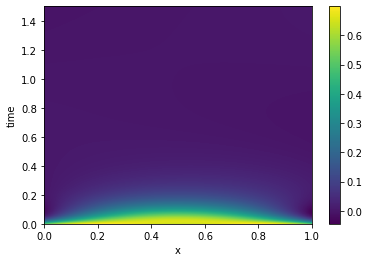

In [9]:
c=plt.pcolormesh(nx,nt,p) 
plt.colorbar(c)
plt.xlabel('x')
plt.ylabel('time')
plt.show()

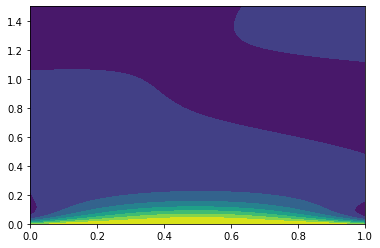

In [10]:
fig, ax = plt.subplots(1, 1)
ax.contourf(nx, nt, p)

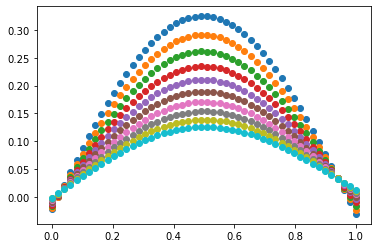

In [19]:
x=np.linspace(0,1,50).reshape(-1,1)
for i in range(10,20):
    t=(i+1)*0.01*np.ones((50,1)).reshape(-1,1)
    X=np.concatenate([x,t],axis=1)
    phi=model(X)
    plt.scatter(x,phi)